## Imports

In [1]:
import os
import math
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from read_data import *
from aux_functions import *

classes_dict = {
    'by_country' : 4,
    'by_style' : 7,
    'by_product' : 2
}

## Set the classification problem

In [2]:
problem_type = 'by_style'

## Set saving / restoring

In [3]:
restoring_mode = False
saving_mode = False

restoring_name = 'first_model.ckpt'
saving_name = 'first_model.ckpt'

restoring_path = os.path.join('models', problem_type, restoring_name)
saving_path = os.path.join('models', problem_type, saving_name)

## Adjust Hyperparameters

In [4]:
EPOCHS = 1e6
BATCH_SIZE = 32
VALIDATION_BATCH = 32

IMG_SIZE = 150
CLASSES = classes_dict[problem_type]

## Neural Network functions

### Convolution Layers

In [5]:
def conv_layer(X, filters, filter_size, name, activation=None):
    """Create a new convolution layer with Xavier initializer"""
    
    with tf.variable_scope(name):
        
        # create Xavier initializer node 
        in_channels = int(X.get_shape()[3])
        init = tf.contrib.layers.xavier_initializer_conv2d()
    
        # create the parameter structures         
        W = tf.get_variable(initializer=init, 
                            shape=(filter_size[0], filter_size[1],
                                   in_channels, filters),
                            name="weights")
        b = tf.get_variable(initializer=tf.zeros(filters),
                            name="biases")
        
        # perform convolution and add bias
        conv = tf.nn.conv2d(X, W, strides=(1, 1, 1, 1), padding="SAME")
        z = tf.nn.bias_add(conv, b)
        
        # activation function
        if activation == "relu":
            return tf.nn.relu(z)
        else:
            return z

        
def pooling_layer(X, kernel_size):
    """Perform max pooling"""
    
    return tf.nn.max_pool(X,
                          ksize=(1, kernel_size[0], kernel_size[1], 1),
                          strides=(1, kernel_size[0], kernel_size[1], 1),
                          padding="VALID")

### Dense Layers

In [6]:
def dense_layer(X, n_neurons, name, activation=None):
    """Create a new fully connected layer with Xavier initializer"""
    
    with tf.variable_scope(name):
        
        # create Xavier initializer node 
        n_inputs = int(X.get_shape()[1])
        init = tf.contrib.layers.xavier_initializer()
        
        # create the parameter structures     
        W = tf.get_variable(initializer=init,
                            shape=(n_inputs, n_neurons),
                            name="weights")
        b = tf.get_variable(initializer=tf.zeros(n_neurons),
                            name="biases")
        z = tf.matmul(X, W) + b
        
        if activation=="relu":
            return tf.nn.relu(z)
        else:
            return z

## Build the model and deploy it on a device

In [7]:
with tf.device('/cpu:0'):
    
    #==================[ READ AND PROCESS THE INPUT ]==================#
    
    # decide the dataset input type
    is_training = tf.placeholder(tf.bool, name="is_training")
        
    # load training data from input queues     
    images_trn, labels_trn = inputs(problem_type, BATCH_SIZE, EPOCHS)
    
    # load validation data from feed dictionary
    images_val = tf.placeholder(tf.uint8, shape=[VALIDATION_BATCH, IMG_SIZE, IMG_SIZE, 3])
    labels_val = tf.placeholder(tf.int32, shape=[VALIDATION_BATCH,])
    
    # choose the input
    images, labels = tf.cond(is_training, lambda: (images_trn, labels_trn),
                                          lambda: (images_val, labels_val))

    # normalize the images     
    images = (tf.cast(images, tf.float32) / 255.0)
    # correct the labels     
    labels = labels - 1

In [8]:
with tf.device('/gpu:0'):

    #==================[ CONVOLUTIONAL LAYERS ]==================#
    
    images_conv_11 = conv_layer(images, 32, (5, 5), "conv_11", "relu")
    images_conv_12 = conv_layer(images_conv_11, 32, (5, 5), "conv_12", "relu")
    images_pool_1  = pooling_layer(images_conv_12, (2, 2))

    images_conv_21 = conv_layer(images_pool_1, 64, (3, 3), "conv_21", "relu")
    images_conv_22 = conv_layer(images_conv_21, 64, (3, 3), "conv_22", "relu")
    images_pool_2  = pooling_layer(images_conv_22, (2, 2))
        
    #==================[     DENSE LAYERS     ]==================#
    
    images_flatten = tf.contrib.layers.flatten(images_pool_2)
    drop_1 = tf.nn.dropout(images_flatten, 0.5, name="drop_1")
    dense_1 = dense_layer(drop_1, 256, "dense_1", "relu")
    drop_2 = tf.nn.dropout(dense_1, 0.5, name="drop_2")
    dense_2 = dense_layer(drop_2, 256, "dense_2", "relu")
    drop_3 = tf.nn.dropout(dense_2, 0.5, name="drop_3")
    
    #==================[     OUTPUT LAYER     ]==================#
    
    logits = dense_layer(drop_3, CLASSES, "logits")
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
    #==================[     OPTIMIZATION     ]==================#
    
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
    training_op = optimizer.minimize(loss)
    
    #==================[      EVALUATION      ]==================#
    
    _train_acc_op, train_accuracy = tf.metrics.accuracy(labels=labels,
                                      predictions=tf.argmax(logits, -1))
    
    _test_acc_op,  test_accuracy  = tf.metrics.accuracy(labels=labels,
                                      predictions=tf.argmax(logits, -1))
    

Instructions for updating:
Use the retry module or similar alternatives.


## Create the session and start the threads for input queues

In [9]:
# create the session saver
saver = tf.train.Saver()

# create a session for running operations in the graph.
sess = tf.Session()

# create the variable initializers
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

# initialize the variables
sess.run(init_op)

if restoring_mode:
    # previously saved model is restored
    saver.restore(sess, restoring_path)
    
# start input enqueue threads.
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

## Collect data for Tensorboard

In [10]:
# clear tensorboard old data
try:
    shutil.rmtree(os.path.join('tensorboard', problem_type))
except FileNotFoundError:
    pass

with tf.device('/cpu:0'):
    
    summary_conv_12 = tf.summary.image('conv_11', images_conv_11[:,:,:,:3])
    summary_conv_22 = tf.summary.image('conv_12', images_conv_12[:,:,:,:3])
    
    train_loss = tf.summary.scalar('training_loss', loss)
    val_loss = tf.summary.scalar('validation_loss', loss)
    train_acc = tf.summary.scalar('training_accuracy', train_accuracy)
    val_acc = tf.summary.scalar('validation_accuracy', test_accuracy)

    convs_merged = tf.summary.merge([summary_conv_12, summary_conv_22])
    train_merged = tf.summary.merge([train_loss, train_acc])
    val_merged = tf.summary.merge([val_loss, val_acc])
    
    summary_writer = tf.summary.FileWriter(
        os.path.join('tensorboard', problem_type), sess.graph)

## Load validation data

In [11]:
# load validation data
images_validation = np.load(os.path.join('data_' + problem_type, 'testing_data.dat'))
labels_validation = np.load(os.path.join('data_' + problem_type, 'testing_labels.dat'))

## Training loop


Step     1 : Training >> loss = 1.966 accuracy = 15.62%  ||  Testing >> loss = 6.343 accuracy = 41.73%
Step     2 : Training >> loss = 7.347 accuracy = 14.06%  ||  Testing >> loss = 3.028 accuracy = 17.32%
Step     3 : Training >> loss = 3.249 accuracy = 13.54%  ||  Testing >> loss = 2.363 accuracy = 16.41%
Step     4 : Training >> loss = 2.213 accuracy = 15.62%  ||  Testing >> loss = 2.093 accuracy = 16.23%
Step     5 : Training >> loss = 2.167 accuracy = 16.88%  ||  Testing >> loss = 2.000 accuracy = 16.15%
Step     6 : Training >> loss = 2.102 accuracy = 15.10%  ||  Testing >> loss = 1.962 accuracy = 16.23%
Step     7 : Training >> loss = 1.901 accuracy = 15.62%  ||  Testing >> loss = 1.947 accuracy = 16.70%
Step     8 : Training >> loss = 1.978 accuracy = 16.80%  ||  Testing >> loss = 1.940 accuracy = 16.76%
Step     9 : Training >> loss = 1.948 accuracy = 15.97%  ||  Testing >> loss = 1.940 accuracy = 16.46%
Step    10 : Training >> loss = 1.925 accuracy = 15.94%  ||  Testing >> 

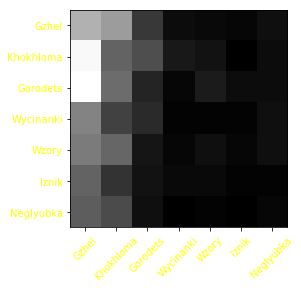


Step    11 : Training >> loss = 1.903 accuracy = 16.76%  ||  Testing >> loss = 1.939 accuracy = 16.19%
Step    12 : Training >> loss = 1.862 accuracy = 17.19%  ||  Testing >> loss = 1.959 accuracy = 16.05%
Step    13 : Training >> loss = 1.848 accuracy = 17.79%  ||  Testing >> loss = 2.004 accuracy = 16.28%
Step    14 : Training >> loss = 1.865 accuracy = 18.53%  ||  Testing >> loss = 1.997 accuracy = 16.37%
Step    15 : Training >> loss = 1.840 accuracy = 18.75%  ||  Testing >> loss = 2.034 accuracy = 16.23%
Step    16 : Training >> loss = 2.051 accuracy = 18.55%  ||  Testing >> loss = 1.995 accuracy = 16.02%
Step    17 : Training >> loss = 1.866 accuracy = 18.75%  ||  Testing >> loss = 1.989 accuracy = 15.82%
Step    18 : Training >> loss = 1.872 accuracy = 19.44%  ||  Testing >> loss = 1.993 accuracy = 15.82%
Step    19 : Training >> loss = 1.913 accuracy = 19.24%  ||  Testing >> loss = 2.025 accuracy = 15.87%
Step    20 : Training >> loss = 1.943 accuracy = 19.06%  ||  Testing >> 

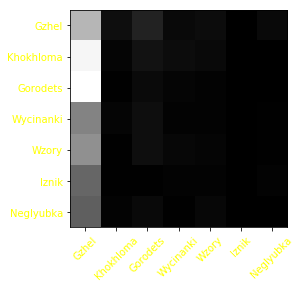


Step    21 : Training >> loss = 1.842 accuracy = 19.35%  ||  Testing >> loss = 2.045 accuracy = 15.52%
Step    22 : Training >> loss = 1.817 accuracy = 19.74%  ||  Testing >> loss = 2.086 accuracy = 15.02%
Step    23 : Training >> loss = 1.832 accuracy = 19.84%  ||  Testing >> loss = 2.169 accuracy = 14.54%
Step    24 : Training >> loss = 1.862 accuracy = 20.18%  ||  Testing >> loss = 2.242 accuracy = 14.04%
Step    25 : Training >> loss = 1.681 accuracy = 21.25%  ||  Testing >> loss = 2.422 accuracy = 13.66%
Step    26 : Training >> loss = 1.721 accuracy = 21.63%  ||  Testing >> loss = 3.077 accuracy = 13.72%
Step    27 : Training >> loss = 2.176 accuracy = 21.64%  ||  Testing >> loss = 2.709 accuracy = 13.34%
Step    28 : Training >> loss = 1.493 accuracy = 22.54%  ||  Testing >> loss = 2.735 accuracy = 12.97%
Step    29 : Training >> loss = 1.591 accuracy = 23.06%  ||  Testing >> loss = 2.783 accuracy = 12.60%
Step    30 : Training >> loss = 1.703 accuracy = 23.13%  ||  Testing >> 

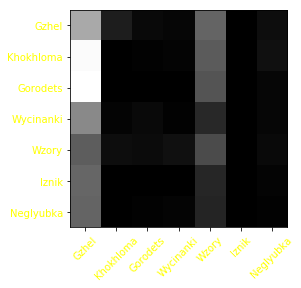


Step    31 : Training >> loss = 2.178 accuracy = 22.88%  ||  Testing >> loss = 2.962 accuracy = 12.57%
Step    32 : Training >> loss = 1.505 accuracy = 23.24%  ||  Testing >> loss = 2.838 accuracy = 12.47%
Step    33 : Training >> loss = 1.564 accuracy = 23.39%  ||  Testing >> loss = 2.719 accuracy = 12.26%
Step    34 : Training >> loss = 1.313 accuracy = 24.36%  ||  Testing >> loss = 2.810 accuracy = 12.02%
Step    35 : Training >> loss = 1.611 accuracy = 24.82%  ||  Testing >> loss = 2.884 accuracy = 11.78%
Step    36 : Training >> loss = 1.415 accuracy = 25.78%  ||  Testing >> loss = 3.106 accuracy = 11.68%
Step    37 : Training >> loss = 1.573 accuracy = 25.76%  ||  Testing >> loss = 3.280 accuracy = 11.65%
Step    38 : Training >> loss = 1.508 accuracy = 25.99%  ||  Testing >> loss = 3.312 accuracy = 11.61%
Step    39 : Training >> loss = 1.357 accuracy = 26.68%  ||  Testing >> loss = 3.572 accuracy = 11.48%
Step    40 : Training >> loss = 1.409 accuracy = 27.03%  ||  Testing >> 

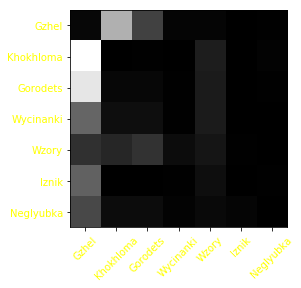


Step    41 : Training >> loss = 1.483 accuracy = 27.59%  ||  Testing >> loss = 3.869 accuracy = 11.08%
Step    42 : Training >> loss = 1.633 accuracy = 27.68%  ||  Testing >> loss = 4.058 accuracy = 10.90%
Step    43 : Training >> loss = 1.745 accuracy = 27.98%  ||  Testing >> loss = 4.017 accuracy = 10.69%
Step    44 : Training >> loss = 1.455 accuracy = 28.27%  ||  Testing >> loss = 3.837 accuracy = 10.50%
Step    45 : Training >> loss = 1.613 accuracy = 28.54%  ||  Testing >> loss = 3.686 accuracy = 10.34%
Step    46 : Training >> loss = 1.605 accuracy = 28.74%  ||  Testing >> loss = 3.626 accuracy = 10.17%
Step    47 : Training >> loss = 1.404 accuracy = 29.06%  ||  Testing >> loss = 3.704 accuracy = 10.08%
Step    48 : Training >> loss = 1.298 accuracy = 29.49%  ||  Testing >> loss = 3.636 accuracy = 10.03%
Step    49 : Training >> loss = 1.367 accuracy = 29.78%  ||  Testing >> loss = 3.482 accuracy =  9.93%
Step    50 : Training >> loss = 1.488 accuracy = 30.00%  ||  Testing >> 

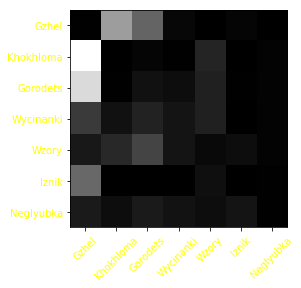


Step    51 : Training >> loss = 1.374 accuracy = 30.51%  ||  Testing >> loss = 3.292 accuracy =  9.67%
Step    52 : Training >> loss = 1.522 accuracy = 30.53%  ||  Testing >> loss = 3.331 accuracy =  9.56%
Step    53 : Training >> loss = 1.636 accuracy = 30.60%  ||  Testing >> loss = 3.374 accuracy =  9.47%
Step    54 : Training >> loss = 1.438 accuracy = 30.61%  ||  Testing >> loss = 3.575 accuracy =  9.43%
Step    55 : Training >> loss = 1.470 accuracy = 30.68%  ||  Testing >> loss = 3.654 accuracy =  9.42%
Step    56 : Training >> loss = 1.339 accuracy = 30.86%  ||  Testing >> loss = 3.680 accuracy =  9.42%
Step    57 : Training >> loss = 1.597 accuracy = 30.70%  ||  Testing >> loss = 3.533 accuracy =  9.37%
Step    58 : Training >> loss = 1.202 accuracy = 31.09%  ||  Testing >> loss = 3.504 accuracy =  9.29%
Step    59 : Training >> loss = 1.208 accuracy = 31.51%  ||  Testing >> loss = 3.608 accuracy =  9.22%
Step    60 : Training >> loss = 1.314 accuracy = 31.72%  ||  Testing >> 

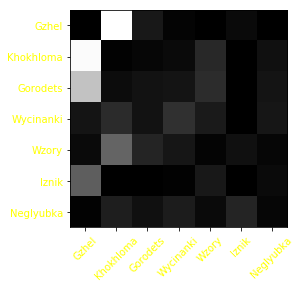


Step    61 : Training >> loss = 1.957 accuracy = 31.66%  ||  Testing >> loss = 3.880 accuracy =  9.08%
Step    62 : Training >> loss = 1.412 accuracy = 31.96%  ||  Testing >> loss = 4.396 accuracy =  9.04%
Step    63 : Training >> loss = 1.351 accuracy = 32.09%  ||  Testing >> loss = 4.681 accuracy =  9.03%
Step    64 : Training >> loss = 1.185 accuracy = 32.47%  ||  Testing >> loss = 4.700 accuracy =  9.03%
Step    65 : Training >> loss = 1.491 accuracy = 32.69%  ||  Testing >> loss = 4.484 accuracy =  9.03%
Step    66 : Training >> loss = 1.145 accuracy = 32.91%  ||  Testing >> loss = 4.382 accuracy =  8.98%
Step    67 : Training >> loss = 1.620 accuracy = 33.02%  ||  Testing >> loss = 3.966 accuracy =  8.90%
Step    68 : Training >> loss = 1.301 accuracy = 33.27%  ||  Testing >> loss = 3.805 accuracy =  8.83%
Step    69 : Training >> loss = 1.184 accuracy = 33.61%  ||  Testing >> loss = 3.961 accuracy =  8.78%
Step    70 : Training >> loss = 1.176 accuracy = 33.93%  ||  Testing >> 

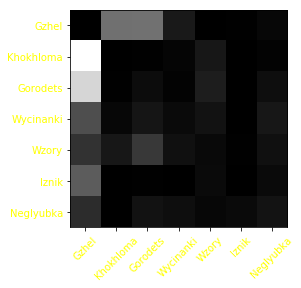


Step    71 : Training >> loss = 1.222 accuracy = 34.11%  ||  Testing >> loss = 4.449 accuracy =  8.63%
Step    72 : Training >> loss = 1.429 accuracy = 34.24%  ||  Testing >> loss = 4.943 accuracy =  8.59%
Step    73 : Training >> loss = 1.178 accuracy = 34.55%  ||  Testing >> loss = 5.499 accuracy =  8.58%
Step    74 : Training >> loss = 1.478 accuracy = 34.54%  ||  Testing >> loss = 5.819 accuracy =  8.57%
Step    75 : Training >> loss = 1.330 accuracy = 34.58%  ||  Testing >> loss = 5.511 accuracy =  8.55%
Step    76 : Training >> loss = 1.252 accuracy = 34.79%  ||  Testing >> loss = 4.799 accuracy =  8.51%
Step    77 : Training >> loss = 1.391 accuracy = 34.78%  ||  Testing >> loss = 4.331 accuracy =  8.46%
Step    78 : Training >> loss = 1.311 accuracy = 34.98%  ||  Testing >> loss = 3.941 accuracy =  8.41%
Step    79 : Training >> loss = 1.196 accuracy = 35.17%  ||  Testing >> loss = 3.884 accuracy =  8.39%
Step    80 : Training >> loss = 1.308 accuracy = 35.47%  ||  Testing >> 

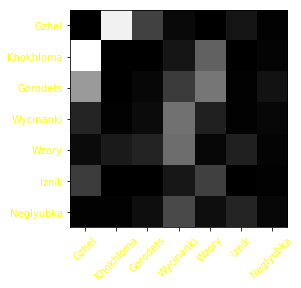


Step    81 : Training >> loss = 1.291 accuracy = 35.65%  ||  Testing >> loss = 4.298 accuracy =  8.36%
Step    82 : Training >> loss = 1.443 accuracy = 35.82%  ||  Testing >> loss = 4.700 accuracy =  8.34%
Step    83 : Training >> loss = 1.441 accuracy = 35.92%  ||  Testing >> loss = 5.588 accuracy =  8.32%
Step    84 : Training >> loss = 1.540 accuracy = 35.90%  ||  Testing >> loss = 5.907 accuracy =  8.31%
Step    85 : Training >> loss = 1.670 accuracy = 35.96%  ||  Testing >> loss = 5.364 accuracy =  8.29%
Step    86 : Training >> loss = 1.474 accuracy = 35.97%  ||  Testing >> loss = 4.679 accuracy =  8.28%
Step    87 : Training >> loss = 1.318 accuracy = 36.10%  ||  Testing >> loss = 4.538 accuracy =  8.25%
Step    88 : Training >> loss = 1.188 accuracy = 36.26%  ||  Testing >> loss = 4.557 accuracy =  8.23%
Step    89 : Training >> loss = 1.434 accuracy = 36.31%  ||  Testing >> loss = 4.600 accuracy =  8.18%
Step    90 : Training >> loss = 1.002 accuracy = 36.53%  ||  Testing >> 

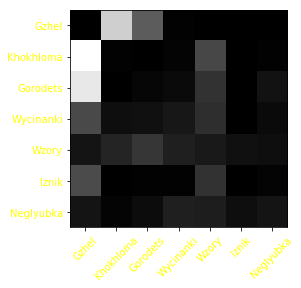


Step    91 : Training >> loss = 1.343 accuracy = 36.57%  ||  Testing >> loss = 4.986 accuracy =  8.10%
Step    92 : Training >> loss = 1.388 accuracy = 36.75%  ||  Testing >> loss = 5.542 accuracy =  8.06%
Step    93 : Training >> loss = 1.119 accuracy = 37.06%  ||  Testing >> loss = 6.371 accuracy =  8.04%
Step    94 : Training >> loss = 1.138 accuracy = 37.33%  ||  Testing >> loss = 7.229 accuracy =  8.03%
Step    95 : Training >> loss = 1.502 accuracy = 37.40%  ||  Testing >> loss = 7.268 accuracy =  8.00%
Step    96 : Training >> loss = 1.456 accuracy = 37.57%  ||  Testing >> loss = 6.550 accuracy =  7.97%
Step    97 : Training >> loss = 1.490 accuracy = 37.50%  ||  Testing >> loss = 6.206 accuracy =  7.92%
Step    98 : Training >> loss = 1.398 accuracy = 37.66%  ||  Testing >> loss = 5.651 accuracy =  7.87%
Step    99 : Training >> loss = 1.258 accuracy = 37.78%  ||  Testing >> loss = 5.299 accuracy =  7.84%
Step   100 : Training >> loss = 1.512 accuracy = 37.78%  ||  Testing >> 

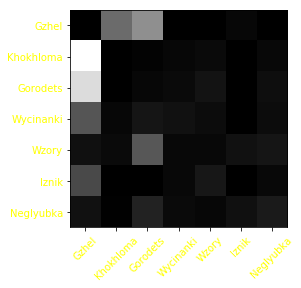


Step   101 : Training >> loss = 1.058 accuracy = 38.06%  ||  Testing >> loss = 5.181 accuracy =  7.75%
Step   102 : Training >> loss = 1.183 accuracy = 38.24%  ||  Testing >> loss = 5.202 accuracy =  7.72%
Step   103 : Training >> loss = 1.474 accuracy = 38.11%  ||  Testing >> loss = 5.513 accuracy =  7.71%
Step   104 : Training >> loss = 1.074 accuracy = 38.34%  ||  Testing >> loss = 5.667 accuracy =  7.70%
Step   105 : Training >> loss = 1.237 accuracy = 38.42%  ||  Testing >> loss = 6.373 accuracy =  7.68%
Step   106 : Training >> loss = 1.254 accuracy = 38.47%  ||  Testing >> loss = 6.944 accuracy =  7.68%
Step   107 : Training >> loss = 1.190 accuracy = 38.58%  ||  Testing >> loss = 7.429 accuracy =  7.67%
Step   108 : Training >> loss = 1.291 accuracy = 38.60%  ||  Testing >> loss = 7.823 accuracy =  7.66%
Step   109 : Training >> loss = 1.451 accuracy = 38.62%  ||  Testing >> loss = 7.871 accuracy =  7.64%
Step   110 : Training >> loss = 1.222 accuracy = 38.69%  ||  Testing >> 

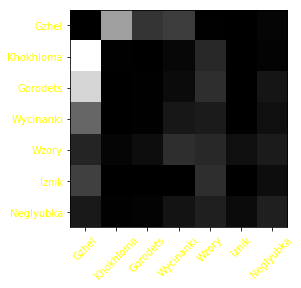


Step   111 : Training >> loss = 0.913 accuracy = 38.94%  ||  Testing >> loss = 8.349 accuracy =  7.62%
Step   112 : Training >> loss = 1.446 accuracy = 38.87%  ||  Testing >> loss = 8.517 accuracy =  7.61%
Step   113 : Training >> loss = 1.168 accuracy = 38.99%  ||  Testing >> loss = 9.272 accuracy =  7.59%
Step   114 : Training >> loss = 1.349 accuracy = 39.09%  ||  Testing >> loss = 10.575 accuracy =  7.58%
Step   115 : Training >> loss = 1.300 accuracy = 39.27%  ||  Testing >> loss = 10.170 accuracy =  7.57%
Step   116 : Training >> loss = 1.077 accuracy = 39.39%  ||  Testing >> loss = 10.030 accuracy =  7.56%
Step   117 : Training >> loss = 1.042 accuracy = 39.53%  ||  Testing >> loss = 9.736 accuracy =  7.55%
Step   118 : Training >> loss = 1.029 accuracy = 39.67%  ||  Testing >> loss = 9.004 accuracy =  7.53%
Step   119 : Training >> loss = 1.155 accuracy = 39.81%  ||  Testing >> loss = 8.047 accuracy =  7.52%
Step   120 : Training >> loss = 1.221 accuracy = 39.82%  ||  Testing 

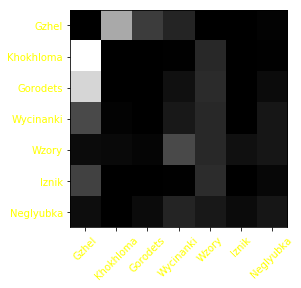


Step   121 : Training >> loss = 1.054 accuracy = 39.95%  ||  Testing >> loss = 7.457 accuracy =  7.49%
Step   122 : Training >> loss = 0.892 accuracy = 40.14%  ||  Testing >> loss = 7.681 accuracy =  7.48%
Step   123 : Training >> loss = 1.198 accuracy = 40.14%  ||  Testing >> loss = 8.216 accuracy =  7.47%
Step   124 : Training >> loss = 1.136 accuracy = 40.22%  ||  Testing >> loss = 8.957 accuracy =  7.45%
Step   125 : Training >> loss = 1.499 accuracy = 40.20%  ||  Testing >> loss = 8.786 accuracy =  7.44%
Step   126 : Training >> loss = 1.183 accuracy = 40.30%  ||  Testing >> loss = 8.627 accuracy =  7.43%
Step   127 : Training >> loss = 1.222 accuracy = 40.40%  ||  Testing >> loss = 8.101 accuracy =  7.42%
Step   128 : Training >> loss = 1.414 accuracy = 40.45%  ||  Testing >> loss = 7.615 accuracy =  7.41%
Step   129 : Training >> loss = 1.416 accuracy = 40.43%  ||  Testing >> loss = 7.085 accuracy =  7.40%
Step   130 : Training >> loss = 1.114 accuracy = 40.58%  ||  Testing >> 

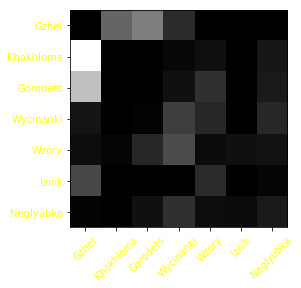


Step   131 : Training >> loss = 1.174 accuracy = 40.60%  ||  Testing >> loss = 6.826 accuracy =  7.39%
Step   132 : Training >> loss = 1.220 accuracy = 40.58%  ||  Testing >> loss = 6.761 accuracy =  7.38%
Step   133 : Training >> loss = 0.982 accuracy = 40.74%  ||  Testing >> loss = 7.235 accuracy =  7.37%
Step   134 : Training >> loss = 0.936 accuracy = 40.95%  ||  Testing >> loss = 7.666 accuracy =  7.36%
Step   135 : Training >> loss = 1.318 accuracy = 41.02%  ||  Testing >> loss = 7.703 accuracy =  7.35%
Step   136 : Training >> loss = 0.970 accuracy = 41.20%  ||  Testing >> loss = 7.593 accuracy =  7.34%
Step   137 : Training >> loss = 1.328 accuracy = 41.17%  ||  Testing >> loss = 7.748 accuracy =  7.33%
Step   138 : Training >> loss = 1.118 accuracy = 41.24%  ||  Testing >> loss = 7.963 accuracy =  7.32%
Step   139 : Training >> loss = 1.220 accuracy = 41.30%  ||  Testing >> loss = 7.351 accuracy =  7.31%
Step   140 : Training >> loss = 0.899 accuracy = 41.45%  ||  Testing >> 

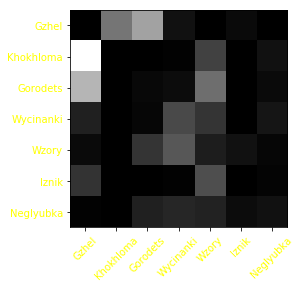


Step   141 : Training >> loss = 1.294 accuracy = 41.49%  ||  Testing >> loss = 7.535 accuracy =  7.31%
Step   142 : Training >> loss = 0.964 accuracy = 41.64%  ||  Testing >> loss = 8.105 accuracy =  7.31%
Step   143 : Training >> loss = 1.072 accuracy = 41.76%  ||  Testing >> loss = 9.399 accuracy =  7.30%
Step   144 : Training >> loss = 1.425 accuracy = 41.84%  ||  Testing >> loss = 9.494 accuracy =  7.29%
Step   145 : Training >> loss = 1.004 accuracy = 41.98%  ||  Testing >> loss = 9.257 accuracy =  7.28%
Step   146 : Training >> loss = 1.325 accuracy = 42.10%  ||  Testing >> loss = 8.304 accuracy =  7.28%
Step   147 : Training >> loss = 1.067 accuracy = 42.24%  ||  Testing >> loss = 7.551 accuracy =  7.26%
Step   148 : Training >> loss = 0.872 accuracy = 42.42%  ||  Testing >> loss = 6.756 accuracy =  7.26%
Step   149 : Training >> loss = 1.157 accuracy = 42.51%  ||  Testing >> loss = 6.262 accuracy =  7.25%
Step   150 : Training >> loss = 1.112 accuracy = 42.56%  ||  Testing >> 

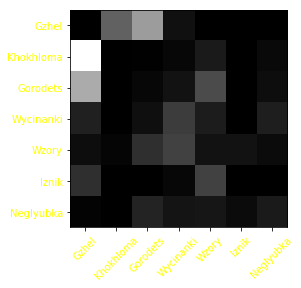


Step   151 : Training >> loss = 1.111 accuracy = 42.67%  ||  Testing >> loss = 6.041 accuracy =  7.26%
Step   152 : Training >> loss = 1.046 accuracy = 42.78%  ||  Testing >> loss = 6.425 accuracy =  7.26%
Step   153 : Training >> loss = 0.827 accuracy = 42.93%  ||  Testing >> loss = 7.029 accuracy =  7.26%
Step   154 : Training >> loss = 1.222 accuracy = 42.96%  ||  Testing >> loss = 7.719 accuracy =  7.25%
Step   155 : Training >> loss = 1.023 accuracy = 43.06%  ||  Testing >> loss = 8.511 accuracy =  7.24%
Step   156 : Training >> loss = 0.862 accuracy = 43.21%  ||  Testing >> loss = 8.709 accuracy =  7.24%
Step   157 : Training >> loss = 1.136 accuracy = 43.29%  ||  Testing >> loss = 9.005 accuracy =  7.23%
Step   158 : Training >> loss = 0.952 accuracy = 43.39%  ||  Testing >> loss = 9.236 accuracy =  7.23%
Step   159 : Training >> loss = 1.149 accuracy = 43.38%  ||  Testing >> loss = 9.282 accuracy =  7.21%
Step   160 : Training >> loss = 0.870 accuracy = 43.54%  ||  Testing >> 

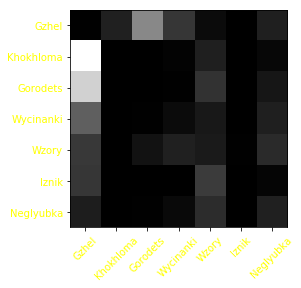


Step   161 : Training >> loss = 0.987 accuracy = 43.65%  ||  Testing >> loss = 9.121 accuracy =  7.19%
Step   162 : Training >> loss = 1.214 accuracy = 43.67%  ||  Testing >> loss = 8.384 accuracy =  7.18%
Step   163 : Training >> loss = 1.277 accuracy = 43.63%  ||  Testing >> loss = 7.528 accuracy =  7.18%
Step   164 : Training >> loss = 1.121 accuracy = 43.73%  ||  Testing >> loss = 7.426 accuracy =  7.19%
Step   165 : Training >> loss = 1.189 accuracy = 43.77%  ||  Testing >> loss = 7.177 accuracy =  7.19%
Step   166 : Training >> loss = 0.926 accuracy = 43.86%  ||  Testing >> loss = 7.587 accuracy =  7.20%
Step   167 : Training >> loss = 1.243 accuracy = 43.92%  ||  Testing >> loss = 7.523 accuracy =  7.20%
Step   168 : Training >> loss = 1.152 accuracy = 43.99%  ||  Testing >> loss = 7.429 accuracy =  7.20%
Step   169 : Training >> loss = 0.913 accuracy = 44.16%  ||  Testing >> loss = 7.568 accuracy =  7.19%
Step   170 : Training >> loss = 1.265 accuracy = 44.15%  ||  Testing >> 

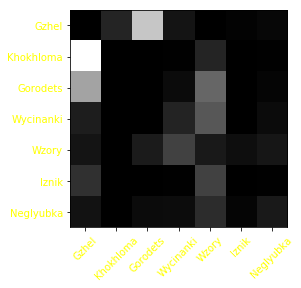


Step   171 : Training >> loss = 1.008 accuracy = 44.26%  ||  Testing >> loss = 8.515 accuracy =  7.18%
Step   172 : Training >> loss = 1.048 accuracy = 44.31%  ||  Testing >> loss = 8.983 accuracy =  7.18%
Step   173 : Training >> loss = 0.938 accuracy = 44.42%  ||  Testing >> loss = 9.361 accuracy =  7.18%
Step   174 : Training >> loss = 1.065 accuracy = 44.50%  ||  Testing >> loss = 9.300 accuracy =  7.17%
Step   175 : Training >> loss = 1.194 accuracy = 44.55%  ||  Testing >> loss = 8.747 accuracy =  7.17%
Step   176 : Training >> loss = 1.101 accuracy = 44.57%  ||  Testing >> loss = 8.627 accuracy =  7.18%
Step   177 : Training >> loss = 0.800 accuracy = 44.63%  ||  Testing >> loss = 8.631 accuracy =  7.17%
Step   178 : Training >> loss = 0.941 accuracy = 44.70%  ||  Testing >> loss = 8.598 accuracy =  7.17%
Step   179 : Training >> loss = 0.900 accuracy = 44.81%  ||  Testing >> loss = 8.394 accuracy =  7.18%
Step   180 : Training >> loss = 0.934 accuracy = 44.91%  ||  Testing >> 

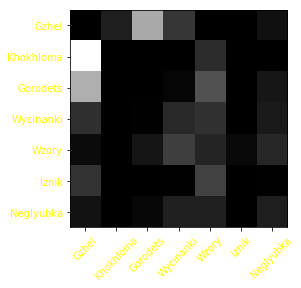


Step   181 : Training >> loss = 0.900 accuracy = 44.98%  ||  Testing >> loss = 8.195 accuracy =  7.18%
Step   182 : Training >> loss = 0.916 accuracy = 45.07%  ||  Testing >> loss = 8.416 accuracy =  7.18%
Step   183 : Training >> loss = 0.860 accuracy = 45.17%  ||  Testing >> loss = 8.629 accuracy =  7.17%
Step   184 : Training >> loss = 0.861 accuracy = 45.28%  ||  Testing >> loss = 8.553 accuracy =  7.17%
Step   185 : Training >> loss = 1.058 accuracy = 45.32%  ||  Testing >> loss = 9.158 accuracy =  7.17%
Step   186 : Training >> loss = 1.133 accuracy = 45.36%  ||  Testing >> loss = 9.190 accuracy =  7.16%
Step   187 : Training >> loss = 0.848 accuracy = 45.49%  ||  Testing >> loss = 9.422 accuracy =  7.16%
Step   188 : Training >> loss = 0.734 accuracy = 45.63%  ||  Testing >> loss = 9.905 accuracy =  7.17%
Step   189 : Training >> loss = 0.885 accuracy = 45.75%  ||  Testing >> loss = 10.848 accuracy =  7.17%
Step   190 : Training >> loss = 0.802 accuracy = 45.89%  ||  Testing >>

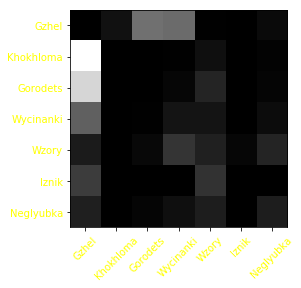


Step   191 : Training >> loss = 1.492 accuracy = 45.91%  ||  Testing >> loss = 11.007 accuracy =  7.16%
Step   192 : Training >> loss = 0.896 accuracy = 45.96%  ||  Testing >> loss = 9.337 accuracy =  7.16%
Step   193 : Training >> loss = 1.196 accuracy = 45.97%  ||  Testing >> loss = 8.659 accuracy =  7.16%
Step   194 : Training >> loss = 1.000 accuracy = 46.04%  ||  Testing >> loss = 7.281 accuracy =  7.16%
Step   195 : Training >> loss = 0.830 accuracy = 46.17%  ||  Testing >> loss = 6.557 accuracy =  7.16%
Step   196 : Training >> loss = 0.976 accuracy = 46.21%  ||  Testing >> loss = 6.180 accuracy =  7.17%
Step   197 : Training >> loss = 1.092 accuracy = 46.26%  ||  Testing >> loss = 6.127 accuracy =  7.17%
Step   198 : Training >> loss = 0.880 accuracy = 46.39%  ||  Testing >> loss = 6.066 accuracy =  7.18%
Step   199 : Training >> loss = 0.846 accuracy = 46.53%  ||  Testing >> loss = 6.017 accuracy =  7.18%
Step   200 : Training >> loss = 1.116 accuracy = 46.58%  ||  Testing >>

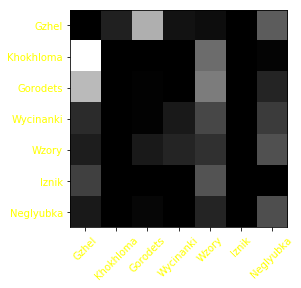


Step   201 : Training >> loss = 0.762 accuracy = 46.72%  ||  Testing >> loss = 6.733 accuracy =  7.20%
Step   202 : Training >> loss = 0.907 accuracy = 46.77%  ||  Testing >> loss = 7.427 accuracy =  7.20%
Step   203 : Training >> loss = 1.016 accuracy = 46.84%  ||  Testing >> loss = 7.721 accuracy =  7.20%
Step   204 : Training >> loss = 0.916 accuracy = 46.88%  ||  Testing >> loss = 8.288 accuracy =  7.21%
Step   205 : Training >> loss = 0.764 accuracy = 47.01%  ||  Testing >> loss = 8.704 accuracy =  7.21%
Step   206 : Training >> loss = 0.794 accuracy = 47.12%  ||  Testing >> loss = 9.064 accuracy =  7.20%
Step   207 : Training >> loss = 0.773 accuracy = 47.25%  ||  Testing >> loss = 9.883 accuracy =  7.20%
Step   208 : Training >> loss = 0.933 accuracy = 47.33%  ||  Testing >> loss = 10.433 accuracy =  7.20%
Step   209 : Training >> loss = 1.052 accuracy = 47.35%  ||  Testing >> loss = 10.830 accuracy =  7.20%
Step   210 : Training >> loss = 0.552 accuracy = 47.49%  ||  Testing >

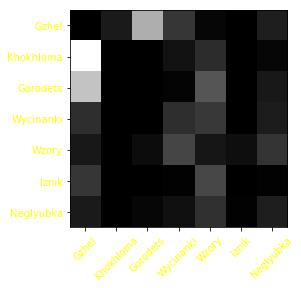


Step   211 : Training >> loss = 0.567 accuracy = 47.60%  ||  Testing >> loss = 11.316 accuracy =  7.19%
Step   212 : Training >> loss = 1.210 accuracy = 47.66%  ||  Testing >> loss = 10.740 accuracy =  7.19%
Step   213 : Training >> loss = 0.774 accuracy = 47.74%  ||  Testing >> loss = 9.347 accuracy =  7.19%
Step   214 : Training >> loss = 0.948 accuracy = 47.79%  ||  Testing >> loss = 8.754 accuracy =  7.19%
Step   215 : Training >> loss = 1.159 accuracy = 47.78%  ||  Testing >> loss = 8.153 accuracy =  7.20%
Step   216 : Training >> loss = 0.772 accuracy = 47.84%  ||  Testing >> loss = 8.563 accuracy =  7.21%
Step   217 : Training >> loss = 0.749 accuracy = 47.94%  ||  Testing >> loss = 8.738 accuracy =  7.22%
Step   218 : Training >> loss = 0.780 accuracy = 47.99%  ||  Testing >> loss = 9.265 accuracy =  7.23%
Step   219 : Training >> loss = 0.557 accuracy = 48.14%  ||  Testing >> loss = 9.933 accuracy =  7.24%
Step   220 : Training >> loss = 1.064 accuracy = 48.20%  ||  Testing >

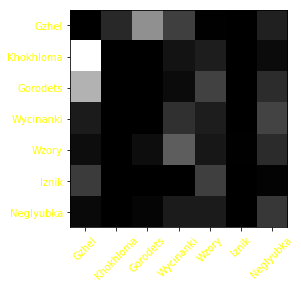


Step   221 : Training >> loss = 1.249 accuracy = 48.22%  ||  Testing >> loss = 11.493 accuracy =  7.26%
Step   222 : Training >> loss = 1.716 accuracy = 48.24%  ||  Testing >> loss = 10.414 accuracy =  7.27%
Step   223 : Training >> loss = 0.992 accuracy = 48.29%  ||  Testing >> loss = 9.631 accuracy =  7.28%
Step   224 : Training >> loss = 1.123 accuracy = 48.33%  ||  Testing >> loss = 8.593 accuracy =  7.28%
Step   225 : Training >> loss = 0.649 accuracy = 48.44%  ||  Testing >> loss = 8.240 accuracy =  7.29%
Step   226 : Training >> loss = 1.051 accuracy = 48.48%  ||  Testing >> loss = 7.474 accuracy =  7.30%
Step   227 : Training >> loss = 0.831 accuracy = 48.55%  ||  Testing >> loss = 7.403 accuracy =  7.30%
Step   228 : Training >> loss = 0.903 accuracy = 48.59%  ||  Testing >> loss = 7.679 accuracy =  7.31%
Step   229 : Training >> loss = 0.915 accuracy = 48.66%  ||  Testing >> loss = 8.626 accuracy =  7.31%
Step   230 : Training >> loss = 0.784 accuracy = 48.76%  ||  Testing >

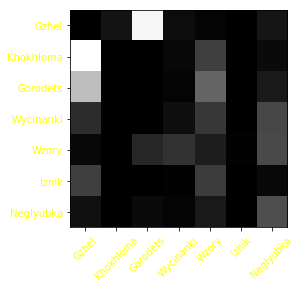


Step   231 : Training >> loss = 0.845 accuracy = 48.84%  ||  Testing >> loss = 10.608 accuracy =  7.32%
Step   232 : Training >> loss = 0.861 accuracy = 48.92%  ||  Testing >> loss = 12.128 accuracy =  7.32%
Step   233 : Training >> loss = 0.629 accuracy = 49.02%  ||  Testing >> loss = 12.904 accuracy =  7.31%
Step   234 : Training >> loss = 0.749 accuracy = 49.11%  ||  Testing >> loss = 14.468 accuracy =  7.31%
Step   235 : Training >> loss = 0.650 accuracy = 49.22%  ||  Testing >> loss = 15.689 accuracy =  7.30%
Step   236 : Training >> loss = 0.681 accuracy = 49.30%  ||  Testing >> loss = 15.955 accuracy =  7.29%
Step   237 : Training >> loss = 0.748 accuracy = 49.38%  ||  Testing >> loss = 15.752 accuracy =  7.29%
Step   238 : Training >> loss = 0.840 accuracy = 49.44%  ||  Testing >> loss = 14.874 accuracy =  7.29%
Step   239 : Training >> loss = 1.204 accuracy = 49.53%  ||  Testing >> loss = 14.580 accuracy =  7.28%
Step   240 : Training >> loss = 1.395 accuracy = 49.49%  ||  Te

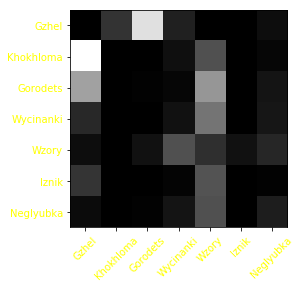


Step   241 : Training >> loss = 0.627 accuracy = 49.61%  ||  Testing >> loss = 13.887 accuracy =  7.27%
Step   242 : Training >> loss = 1.093 accuracy = 49.64%  ||  Testing >> loss = 10.898 accuracy =  7.26%
Step   243 : Training >> loss = 1.075 accuracy = 49.67%  ||  Testing >> loss = 8.791 accuracy =  7.26%
Step   244 : Training >> loss = 0.852 accuracy = 49.73%  ||  Testing >> loss = 7.721 accuracy =  7.27%
Step   245 : Training >> loss = 0.965 accuracy = 49.78%  ||  Testing >> loss = 6.825 accuracy =  7.27%
Step   246 : Training >> loss = 0.932 accuracy = 49.86%  ||  Testing >> loss = 6.223 accuracy =  7.26%
Step   247 : Training >> loss = 0.736 accuracy = 49.99%  ||  Testing >> loss = 6.201 accuracy =  7.26%
Step   248 : Training >> loss = 0.987 accuracy = 50.04%  ||  Testing >> loss = 6.335 accuracy =  7.27%
Step   249 : Training >> loss = 0.888 accuracy = 50.13%  ||  Testing >> loss = 6.605 accuracy =  7.27%
Step   250 : Training >> loss = 1.134 accuracy = 50.13%  ||  Testing >

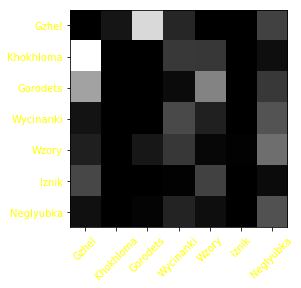


Step   251 : Training >> loss = 0.994 accuracy = 50.16%  ||  Testing >> loss = 7.099 accuracy =  7.28%
Step   252 : Training >> loss = 0.968 accuracy = 50.20%  ||  Testing >> loss = 7.447 accuracy =  7.28%
Step   253 : Training >> loss = 0.951 accuracy = 50.26%  ||  Testing >> loss = 7.993 accuracy =  7.29%
Step   254 : Training >> loss = 0.620 accuracy = 50.39%  ||  Testing >> loss = 8.186 accuracy =  7.30%
Step   255 : Training >> loss = 0.688 accuracy = 50.49%  ||  Testing >> loss = 8.595 accuracy =  7.30%
Step   256 : Training >> loss = 0.938 accuracy = 50.51%  ||  Testing >> loss = 9.056 accuracy =  7.31%
Step   257 : Training >> loss = 0.739 accuracy = 50.60%  ||  Testing >> loss = 9.950 accuracy =  7.31%
Step   258 : Training >> loss = 0.907 accuracy = 50.65%  ||  Testing >> loss = 11.262 accuracy =  7.31%
Step   259 : Training >> loss = 0.970 accuracy = 50.70%  ||  Testing >> loss = 12.278 accuracy =  7.31%
Step   260 : Training >> loss = 0.650 accuracy = 50.79%  ||  Testing >

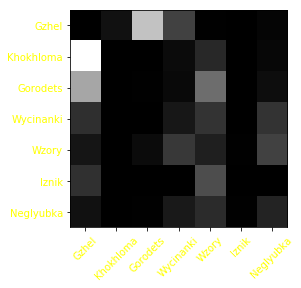


Step   261 : Training >> loss = 0.670 accuracy = 50.86%  ||  Testing >> loss = 13.615 accuracy =  7.31%
Step   262 : Training >> loss = 0.774 accuracy = 50.94%  ||  Testing >> loss = 12.625 accuracy =  7.30%
Step   263 : Training >> loss = 1.103 accuracy = 50.97%  ||  Testing >> loss = 10.705 accuracy =  7.31%
Step   264 : Training >> loss = 0.980 accuracy = 50.96%  ||  Testing >> loss = 9.544 accuracy =  7.31%
Step   265 : Training >> loss = 0.835 accuracy = 50.99%  ||  Testing >> loss = 9.258 accuracy =  7.32%
Step   266 : Training >> loss = 0.605 accuracy = 51.08%  ||  Testing >> loss = 9.303 accuracy =  7.32%
Step   267 : Training >> loss = 0.692 accuracy = 51.14%  ||  Testing >> loss = 9.683 accuracy =  7.32%
Step   268 : Training >> loss = 0.571 accuracy = 51.28%  ||  Testing >> loss = 10.148 accuracy =  7.33%
Step   269 : Training >> loss = 0.591 accuracy = 51.37%  ||  Testing >> loss = 10.448 accuracy =  7.33%
Step   270 : Training >> loss = 0.584 accuracy = 51.47%  ||  Testin

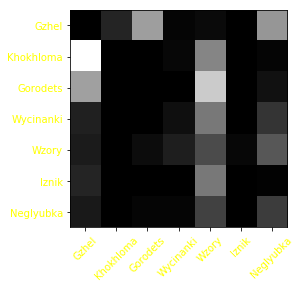


Step   271 : Training >> loss = 0.815 accuracy = 51.52%  ||  Testing >> loss = 11.057 accuracy =  7.33%
Step   272 : Training >> loss = 0.959 accuracy = 51.55%  ||  Testing >> loss = 10.792 accuracy =  7.34%
Step   273 : Training >> loss = 0.856 accuracy = 51.58%  ||  Testing >> loss = 9.795 accuracy =  7.34%
Step   274 : Training >> loss = 0.778 accuracy = 51.64%  ||  Testing >> loss = 9.006 accuracy =  7.35%
Step   275 : Training >> loss = 0.938 accuracy = 51.73%  ||  Testing >> loss = 8.592 accuracy =  7.34%
Step   276 : Training >> loss = 0.853 accuracy = 51.78%  ||  Testing >> loss = 8.584 accuracy =  7.35%
Step   277 : Training >> loss = 0.660 accuracy = 51.85%  ||  Testing >> loss = 8.532 accuracy =  7.36%
Step   278 : Training >> loss = 0.815 accuracy = 51.91%  ||  Testing >> loss = 9.148 accuracy =  7.37%
Step   279 : Training >> loss = 0.515 accuracy = 52.03%  ||  Testing >> loss = 9.832 accuracy =  7.37%
Step   280 : Training >> loss = 0.736 accuracy = 52.11%  ||  Testing >

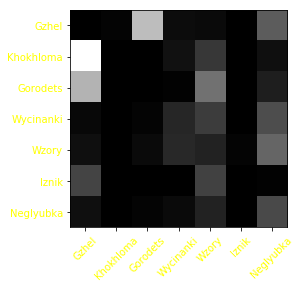

In [ ]:
try:
    step = 0
    MILESTONE = 1
    CONFUSSION_MILESTONE = 10 * MILESTONE
    
    min_val_loss = math.inf
    max_val_acc = -math.inf
    
    acc_sum = 0
    loss_sum = 0
    samples_count = 0
    
    # feed data until the epoch limit is reached     
    while not coord.should_stop():

        step += 1
        
        _, loss_value, acc_value, summary, img_sum = sess.run(
                [training_op, loss, train_accuracy, train_merged, convs_merged], feed_dict={
            is_training : True,
            images_val : images_validation[:VALIDATION_BATCH],
            labels_val : labels_validation[:VALIDATION_BATCH]
        })
        
        # save stats to log         
        summary_writer.add_summary(summary, step)
        summary_writer.add_summary(img_sum, step)
        
        acc_sum += acc_value
        loss_sum += loss_value
        samples_count += 1
                
            
        if step % MILESTONE == 0:
        
            #===================[ TRAINING SCORE ]===================#
            
            training_acc = acc_sum / samples_count
            training_loss = loss_sum / samples_count
                
            print("\nStep {0:5d} : Training >> loss = {1:.3f} accuracy = {2:5.2f}%" \
                  .format(step, training_loss, 100 * training_acc), flush=True, end="")
            
            acc_sum = 0
            loss_sum = 0
            samples_count = 0  
        
            #===================[ TESTING SCORE ]===================#
            
            val_acc_sum = 0
            val_loss_sum = 0
            val_samples_count = 0  
            confussion_matrix = np.zeros((CLASSES, CLASSES), dtype=np.int32)
            
            for i in range(VALIDATION_BATCH, len(labels_validation), VALIDATION_BATCH):
                
                loss_value, acc_value, true, pred, summary = sess.run(
                    [loss, test_accuracy, labels, logits, val_merged], feed_dict={
                    is_training : False,
                    images_val : images_validation[(i - VALIDATION_BATCH):i],
                    labels_val : labels_validation[(i - VALIDATION_BATCH):i]
                })
                
                val_acc_sum += acc_value
                val_loss_sum += loss_value
                val_samples_count += 1
                for i in range(len(true)):
                    confussion_matrix[true[i], np.argmax(pred[i])] += 1
                                
            # save stats to log         
            summary_writer.add_summary(summary, step)
                
            validation_acc = val_acc_sum / val_samples_count
            validation_loss = val_loss_sum / val_samples_count
            
            print("  ||  Testing >> loss = {1:.3f} accuracy = {2:5.2f}%" \
                  .format(step, validation_loss, 100 * validation_acc), flush=True, end="")
                        
            # display confussion matrix             
            if step % CONFUSSION_MILESTONE == 0:
                display_confussion_matrix(confussion_matrix, problem_type)
                
            saving_condition = (validation_loss < min_val_loss)

            # save the model for later use         
            if saving_mode and saving_condition:
                saver.save(sess, saving_path)
                
            min_val_loss = min(min_val_loss, validation_loss)
            max_val_acc  = max(max_val_acc,  validation_acc)
        
        
except tf.errors.OutOfRangeError:
    
    print('\nDone training -- epoch limit reached\n')
    
finally:
    
    # when done, ask the threads to stop
    coord.request_stop()

    # wait for threads to finish
    coord.join(threads)
    sess.close()